# ML Next Step Project: ASL Alphabet

Dataset link (Kaggle):

https://www.kaggle.com/datasets/grassknoted/asl-alphabet

The dataset was manually altered a bit to expand the test dataset.

2262 training images per class.

## Data Importing & Quick Look Into It

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# Importing data
zip_ref = zipfile.ZipFile("drive/MyDrive/data/ASL_totally_good.zip", 'r')
zip_ref.extractall()
zip_ref.close()

## Visualizing Random Data Samples

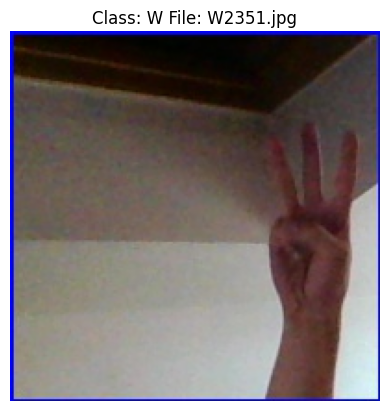

In [24]:
import matplotlib.pyplot as plt
import random
import os

def view_random_img(target_dir, target_class):
    target_folder = target_dir + "/" + target_class
    random_img = random.sample(os.listdir(target_folder), 1)
    img = plt.imread(target_folder + "/" + random_img[0])
    plt.title("Class: " + target_class + " File: " + random_img[0])
    plt.axis(False)
    plt.imshow(img)

view_random_img("ASL_totally_good/asl_alphabet_train", "W")

## Data Splitting & Creating Data Loaders

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(), # [0, 1] range
    transforms.Normalize((0.5,), (0.5,)) # wanted [-1, 1] range
])

dataset = ImageFolder(root="ASL_totally_good/asl_alphabet_train", transform=transform)

BATCH_SIZE = 64
TRAIN_SIZE = int(0.8 * len(dataset)) # 80:20 split
VAL_SIZE = len(dataset) - TRAIN_SIZE
train_dataset, val_dataset = random_split(dataset, [TRAIN_SIZE, VAL_SIZE])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"Training set size: {TRAIN_SIZE}, validation set size: {VAL_SIZE}")
print(f"Training images per class: {TRAIN_SIZE // 29}, validation images per class: {VAL_SIZE // 29}")

cpu
Training set size: 65609, validation set size: 16403
Training images per class: 2262, validation images per class: 565


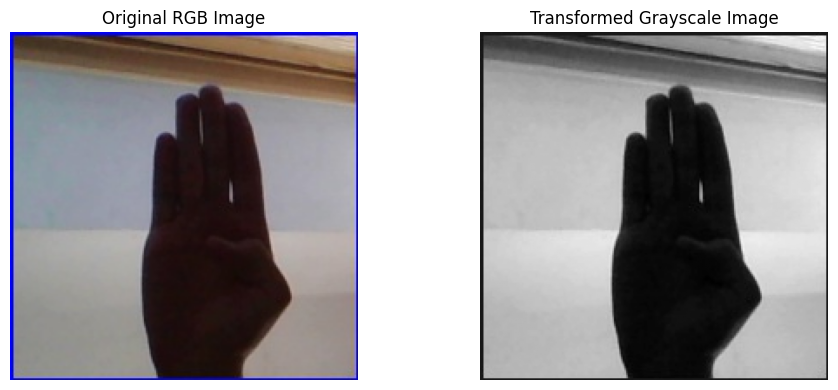

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

img_path = "ASL_totally_good/asl_alphabet_train/B/B1.jpg"
original_img = Image.open(img_path)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

transformed_tensor = transform(original_img).squeeze(0)  # [1, H, W] → [H, W] for display

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Original RGB Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_tensor, cmap='gray')
plt.title("Transformed Grayscale Image")
plt.axis('off')

plt.tight_layout()
plt.show()


## Modelling: Creating the CNN

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, NUM_CLASSES))

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

## Training Loop - Grayscale Images

In [12]:
print(device)

cuda


In [13]:
# Training parameters
CLASSES = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'del', 'nothing', 'space'
]

NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_CLASSES = len(CLASSES) # 29

In [ ]:
model = CNN().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    train_losses.append(running_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_accuracy:.2f}%\n")
    val_accuracies.append(val_accuracy)

Epoch [1/5], Loss: 1394.6721, Accuracy: 56.18%
Validation Accuracy: 87.01%

Epoch [2/5], Loss: 548.4585, Accuracy: 81.18%
Validation Accuracy: 93.27%

Epoch [3/5], Loss: 375.0364, Accuracy: 86.88%
Validation Accuracy: 95.79%

Epoch [4/5], Loss: 280.2629, Accuracy: 90.16%
Validation Accuracy: 96.81%

Epoch [5/5], Loss: 223.7232, Accuracy: 92.17%
Validation Accuracy: 97.43%



**Epoch training time: around 3.5
 minutes**

### Saving & Loading Model

In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/models/asl_cnn_model_grayscale.pth")

In [11]:
NUM_CLASSES = 29
MODEL_PATH = "drive/MyDrive/models/asl_cnn_model_grayscale.pth"
model = CNN()
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)
model.eval()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
print(model.state_dict())

OrderedDict([('conv_layer.0.weight', tensor([[[[-0.1195,  0.2594,  0.2740],
          [ 0.3563, -0.2066,  0.2055],
          [-0.2644,  0.3373,  0.2930]]],


        [[[-0.1304, -0.2398, -0.0081],
          [-0.3428,  0.0790,  0.1781],
          [-0.3474, -0.4572, -0.0917]]],


        [[[ 0.0966,  0.1123,  0.0654],
          [ 0.1717,  0.3241,  0.0739],
          [ 0.1855,  0.2247,  0.1855]]],


        [[[-0.0374,  0.2334, -0.3044],
          [ 0.0615, -0.1533, -0.2340],
          [ 0.3961, -0.2017, -0.5537]]],


        [[[-0.0555,  0.3213,  0.0722],
          [-0.1051,  0.0164,  0.4236],
          [ 0.4415, -0.1230,  0.2367]]],


        [[[ 0.0644, -0.1195, -0.3600],
          [-0.1264, -0.3955, -0.1325],
          [-0.3365, -0.0639, -0.1923]]],


        [[[ 0.4579,  0.0900,  0.4075],
          [ 0.3206,  0.0612,  0.0155],
          [ 0.2496,  0.3198, -0.2554]]],


        [[[ 0.2009,  0.2436,  0.3671],
          [ 0.2653, -0.0684,  0.3787],
          [ 0.0980,  0.1163,  0.3411]]

### Visualizing Losses & Accuracies

range(1, 6)
[56.17979240652959, 81.17788718011248, 86.87527625783048, 90.16293496319102, 92.16723315398802]


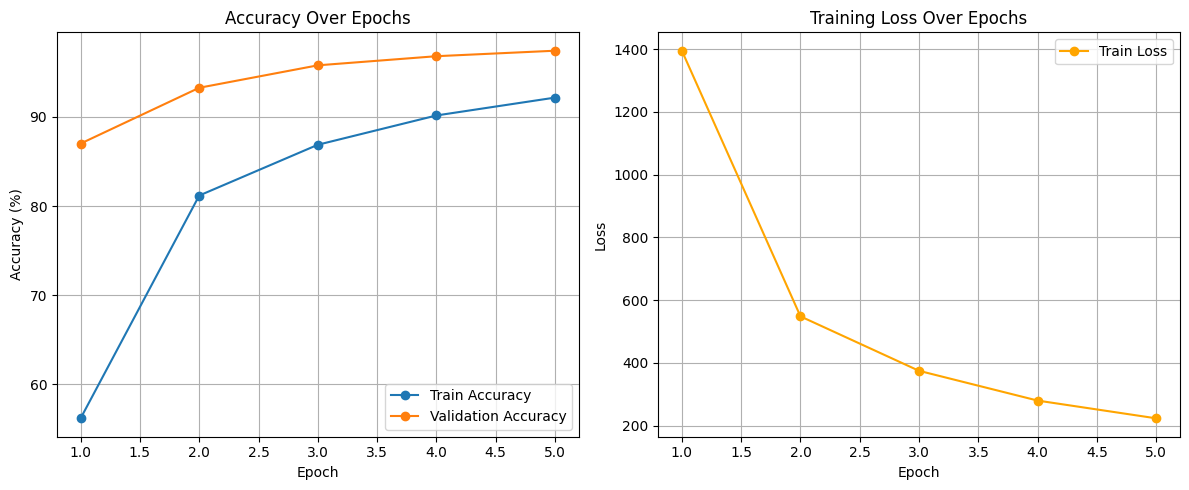

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', color='orange', marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Training Loop - RGB - Experiment

In [14]:
class CNN_RGB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 200, 200)  # [B, C, H, W]
            dummy_output = self.conv_layer(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(.50),
            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [ ]:
NUM_EPOCHS = 5

transform_rgb = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(), # [0, 1] range
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # wanted [-1, 1] range
])

dataset_rgb = ImageFolder(root="ASL_totally_good/asl_alphabet_train", transform=transform_rgb)
TRAIN_SIZE = int(0.8 * len(dataset_rgb))
VAL_SIZE = len(dataset_rgb) - TRAIN_SIZE # 80:20 split

train_dataset_rgb, val_dataset_rgb = random_split(dataset_rgb, [TRAIN_SIZE, VAL_SIZE])

train_loader_rgb = DataLoader(train_dataset_rgb, batch_size=BATCH_SIZE, shuffle=True)
val_loader_rgb = DataLoader(val_dataset_rgb, batch_size=BATCH_SIZE, shuffle=True)

model_rgb = CNN_RGB().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rgb.parameters(), lr=LEARNING_RATE)

train_losses_rgb = []
train_accuracies_rgb = []
val_accuracies_rgb = []

for epoch in range(NUM_EPOCHS):
    model_rgb.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader_rgb:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_rgb(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    train_losses_rgb.append(running_loss)
    train_accuracies_rgb.append(train_accuracy)

    # Validation
    model_rgb.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader_rgb:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model_rgb(val_images)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_accuracy:.2f}%\n")
    val_accuracies_rgb.append(val_accuracy)

Epoch [1/5], Loss: 1493.0499, Accuracy: 52.36%
Validation Accuracy: 81.01%

Epoch [2/5], Loss: 516.4830, Accuracy: 81.92%
Validation Accuracy: 91.43%

Epoch [3/5], Loss: 322.0097, Accuracy: 88.73%
Validation Accuracy: 93.45%

Epoch [4/5], Loss: 225.4933, Accuracy: 92.15%
Validation Accuracy: 96.19%

Epoch [5/5], Loss: 181.6698, Accuracy: 93.68%
Validation Accuracy: 97.24%



In [ ]:
torch.save(model.state_dict(), "drive/MyDrive/models/asl_cnn_model_rgb.pth")

## Training Loop - Grayscale with Stride=3 - Experiment 2

In [15]:
class CNN_TEST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Dynamically compute flattened size using a dummy input
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, 200, 200)  # [B, C, H, W]
            dummy_output = self.conv_layer(dummy_input)
            flattened_size = dummy_output.view(1, -1).shape[1]

        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x


In [ ]:
model = CNN_TEST().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses_stride_3 = []
train_accuracies_stride_3 = []
val_accuracies_stride_3 = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics update
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

    train_losses_stride_3.append(running_loss)
    train_accuracies_stride_3.append(train_accuracy)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_accuracy:.2f}%\n")
    val_accuracies_stride_3.append(val_accuracy)

Epoch [1/5], Loss: 1665.6114, Accuracy: 47.61%
Validation Accuracy: 77.46%

Epoch [2/5], Loss: 617.3658, Accuracy: 78.56%
Validation Accuracy: 87.91%

Epoch [3/5], Loss: 407.6114, Accuracy: 85.74%
Validation Accuracy: 92.43%

Epoch [4/5], Loss: 304.8512, Accuracy: 89.14%
Validation Accuracy: 94.45%

Epoch [5/5], Loss: 241.0603, Accuracy: 91.53%
Validation Accuracy: 95.85%



### Comparing Grayscale with Stride = 1 against Grayscale with Stride = 3

range(1, 6)
[56.17979240652959, 81.17788718011248, 86.87527625783048, 90.16293496319102, 92.16723315398802]


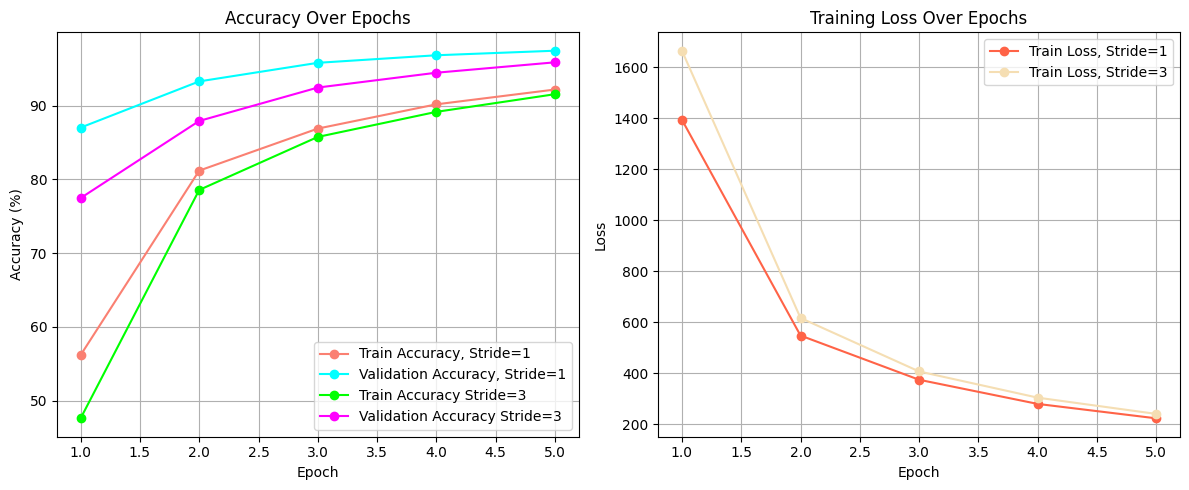

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

EPOCHS = range(1, NUM_EPOCHS + 1)
print(EPOCHS)
print(train_accuracies)
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(EPOCHS, train_accuracies, label='Train Accuracy, Stride=1', marker='o', color='salmon')
plt.plot(EPOCHS, val_accuracies, label='Validation Accuracy, Stride=1', marker='o', color='cyan')
plt.plot(EPOCHS, train_accuracies_stride_3, label='Train Accuracy Stride=3', marker='o', color='lime')
plt.plot(EPOCHS, val_accuracies_stride_3, label='Validation Accuracy Stride=3', marker='o', color='fuchsia')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(EPOCHS, train_losses, label='Train Loss, Stride=1', marker='o', color='tomato')
plt.plot(EPOCHS, train_losses_stride_3, label='Train Loss, Stride=3', marker='o', color='wheat')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Training time per epoch: **~1.5mins**

## Testing the Model

In [9]:
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = ImageFolder(root="ASL_totally_good/asl_alphabet_test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
model = CNN().to(device)
model.load_state_dict(torch.load("drive/MyDrive/models/asl_cnn_model_grayscale.pth"))
model.eval()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=80000, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=29, bias=True)
  )
)

In [17]:
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"✅ Test Accuracy: {test_accuracy:.2f}%")

✅ Test Accuracy: 99.20%


### Visualizing Random Model Predictions

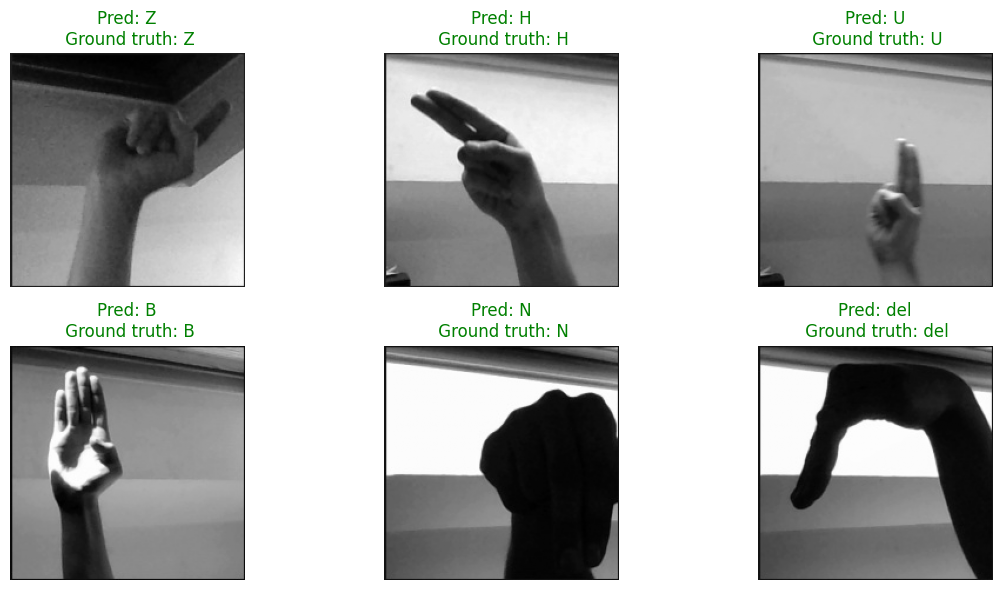

In [18]:
import random

class_names = test_dataset.classes

model.eval()
all_preds = []
all_labels = []
all_imgs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_imgs.extend(images.cpu())  #

indices = random.sample(range(len(all_imgs)), 6)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    img = all_imgs[idx].squeeze(0).numpy()  # grayscale: [1,H,W] → [H,W]
    true_label = class_names[all_labels[idx]]
    pred_label = class_names[all_preds[idx]]

    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Pred: {pred_label}\n Ground truth: {true_label}",
              color='green' if pred_label == true_label else 'red')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Confusion Matrix - what it got wrong

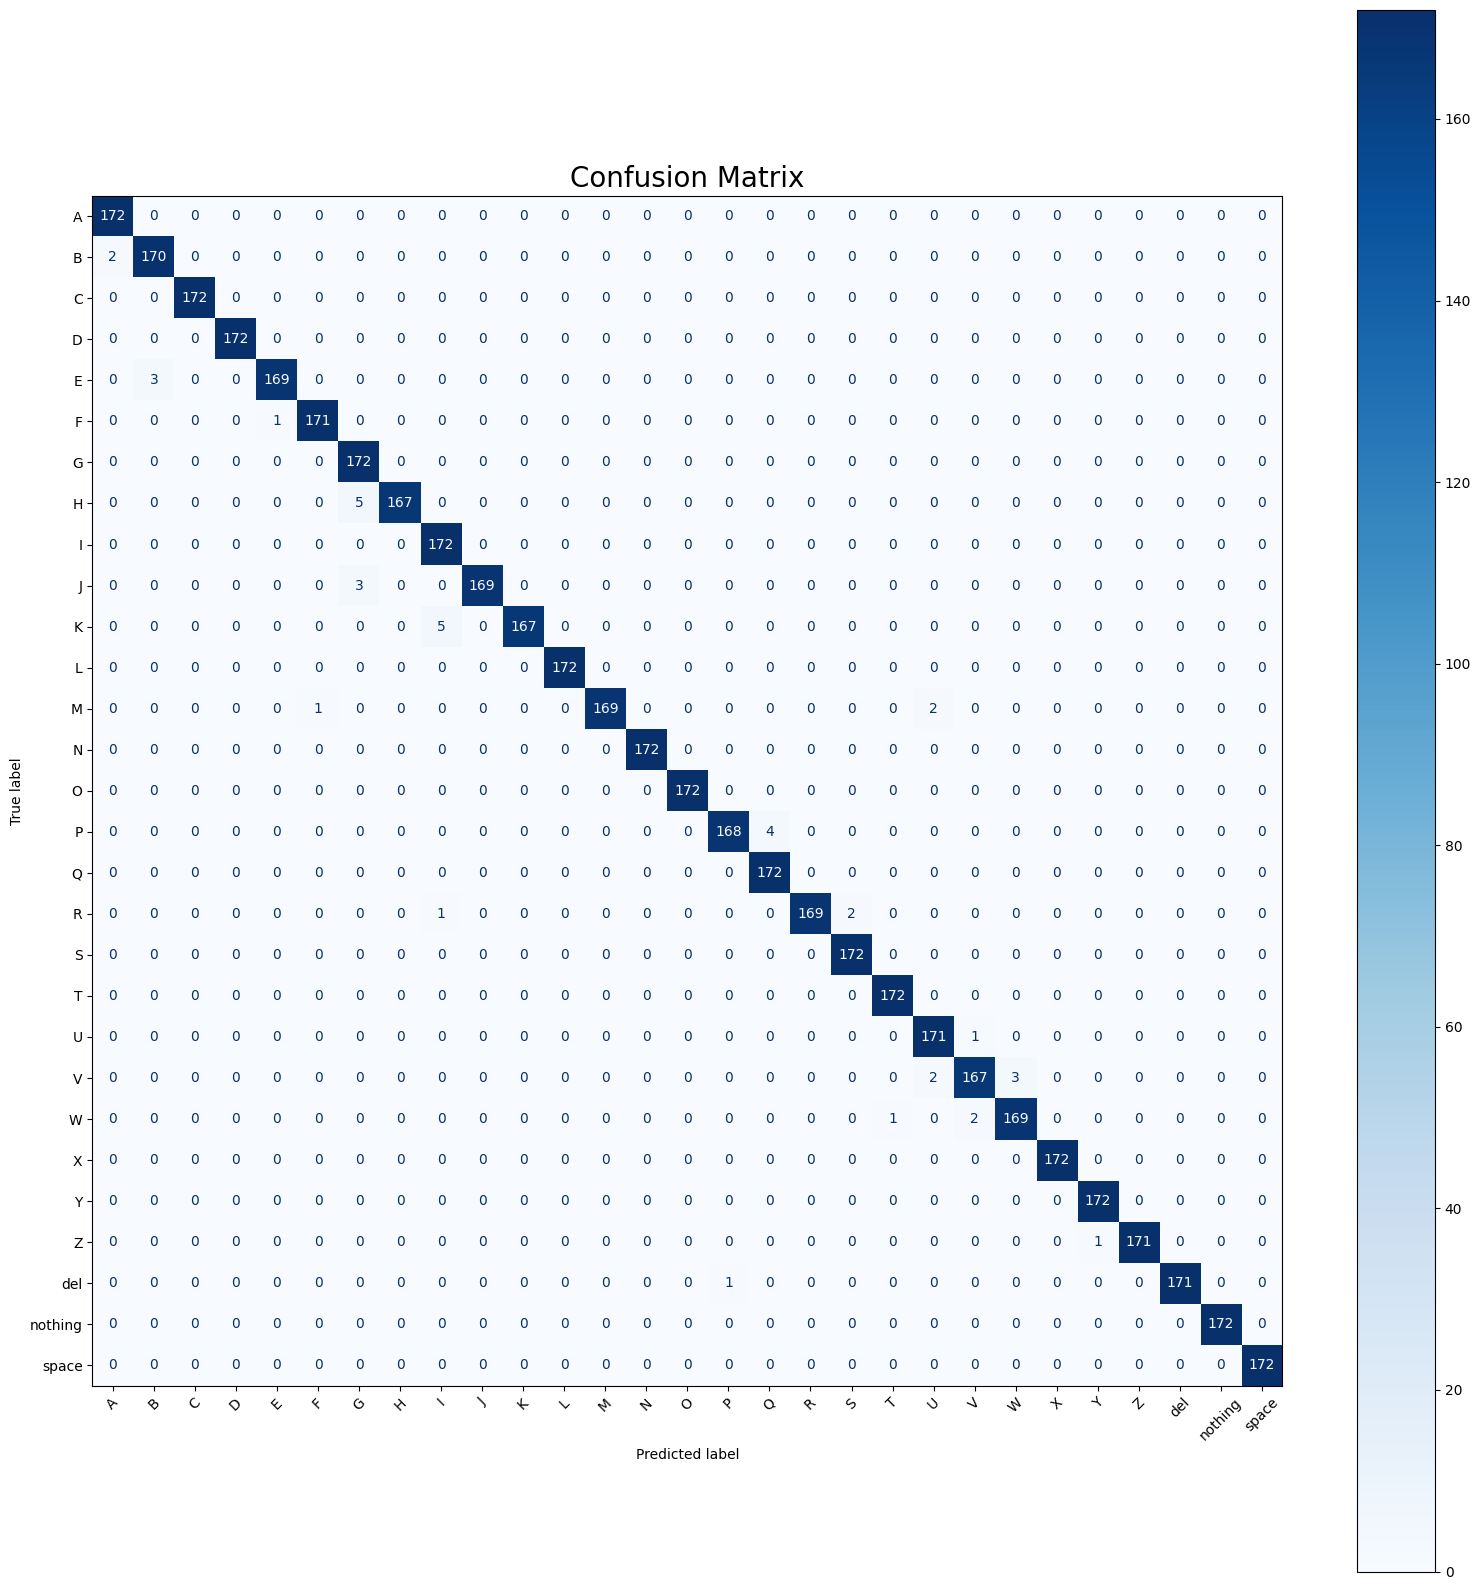

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute confusion matrix again if needed
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes

# Create larger plot
fig, ax = plt.subplots(figsize=(16, 16))  # increase figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

disp.plot(
    cmap="Blues",
    xticks_rotation=45,
    ax=ax,
    values_format='d'  # show raw counts
)

plt.title("Confusion Matrix", fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Checking Out Wrong Predictions

In [20]:
misclassified = []

for img, true, pred in zip(all_imgs, all_labels, all_preds):
    if pred != true:
        misclassified.append((img, true, pred))

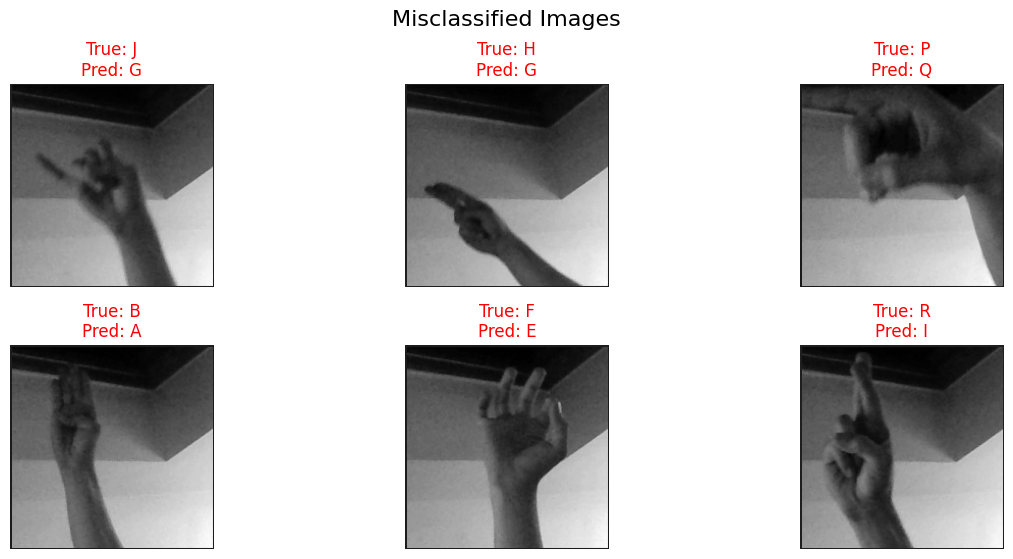

In [21]:
import random

samples = random.sample(misclassified, 6)

plt.figure(figsize=(12, 8))

for i, (img, true, pred) in enumerate(samples):
    img_np = img.squeeze().numpy()

    plt.subplot(3, 3, i+1)
    plt.imshow(img_np, cmap='gray')
    plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}",
              color='red')
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Misclassified Images", fontsize=16, y=1.02)
plt.show()


## Live Predicting :D

In [13]:
from PIL import Image
import torch
import torchvision.transforms as transforms

image_path = "/content/drive/MyDrive/data/live/a.jpg"
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = test_dataset.classes

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
display(image)
image = Image.open(image_path)
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)
    _, predicted_idx = torch.max(output, 1)

print(output)
predicted_class = class_names[predicted_idx.item()]
print(f"🧠 Predicted ASL Class: {predicted_class}")


NameError: name 'test_dataset' is not defined

## Visual Analysis of CNN Activations

Loading image: /content/ASL_totally_good/asl_alphabet_test/A/A1007.jpg
Image loaded successfully: Mode=RGB, Size=(200, 200)
Forward pass completed. Captured 3 feature map sets.

Plotting for Layer: Conv Block 1 Output (32 channels, plotting up to 8) (8 of 32 channels)


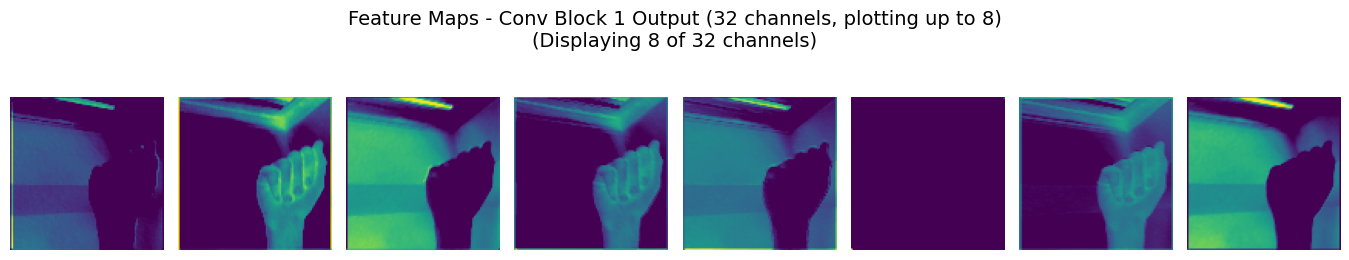


Plotting for Layer: Conv Block 2 Output (64 channels, plotting up to 64) (64 of 64 channels)


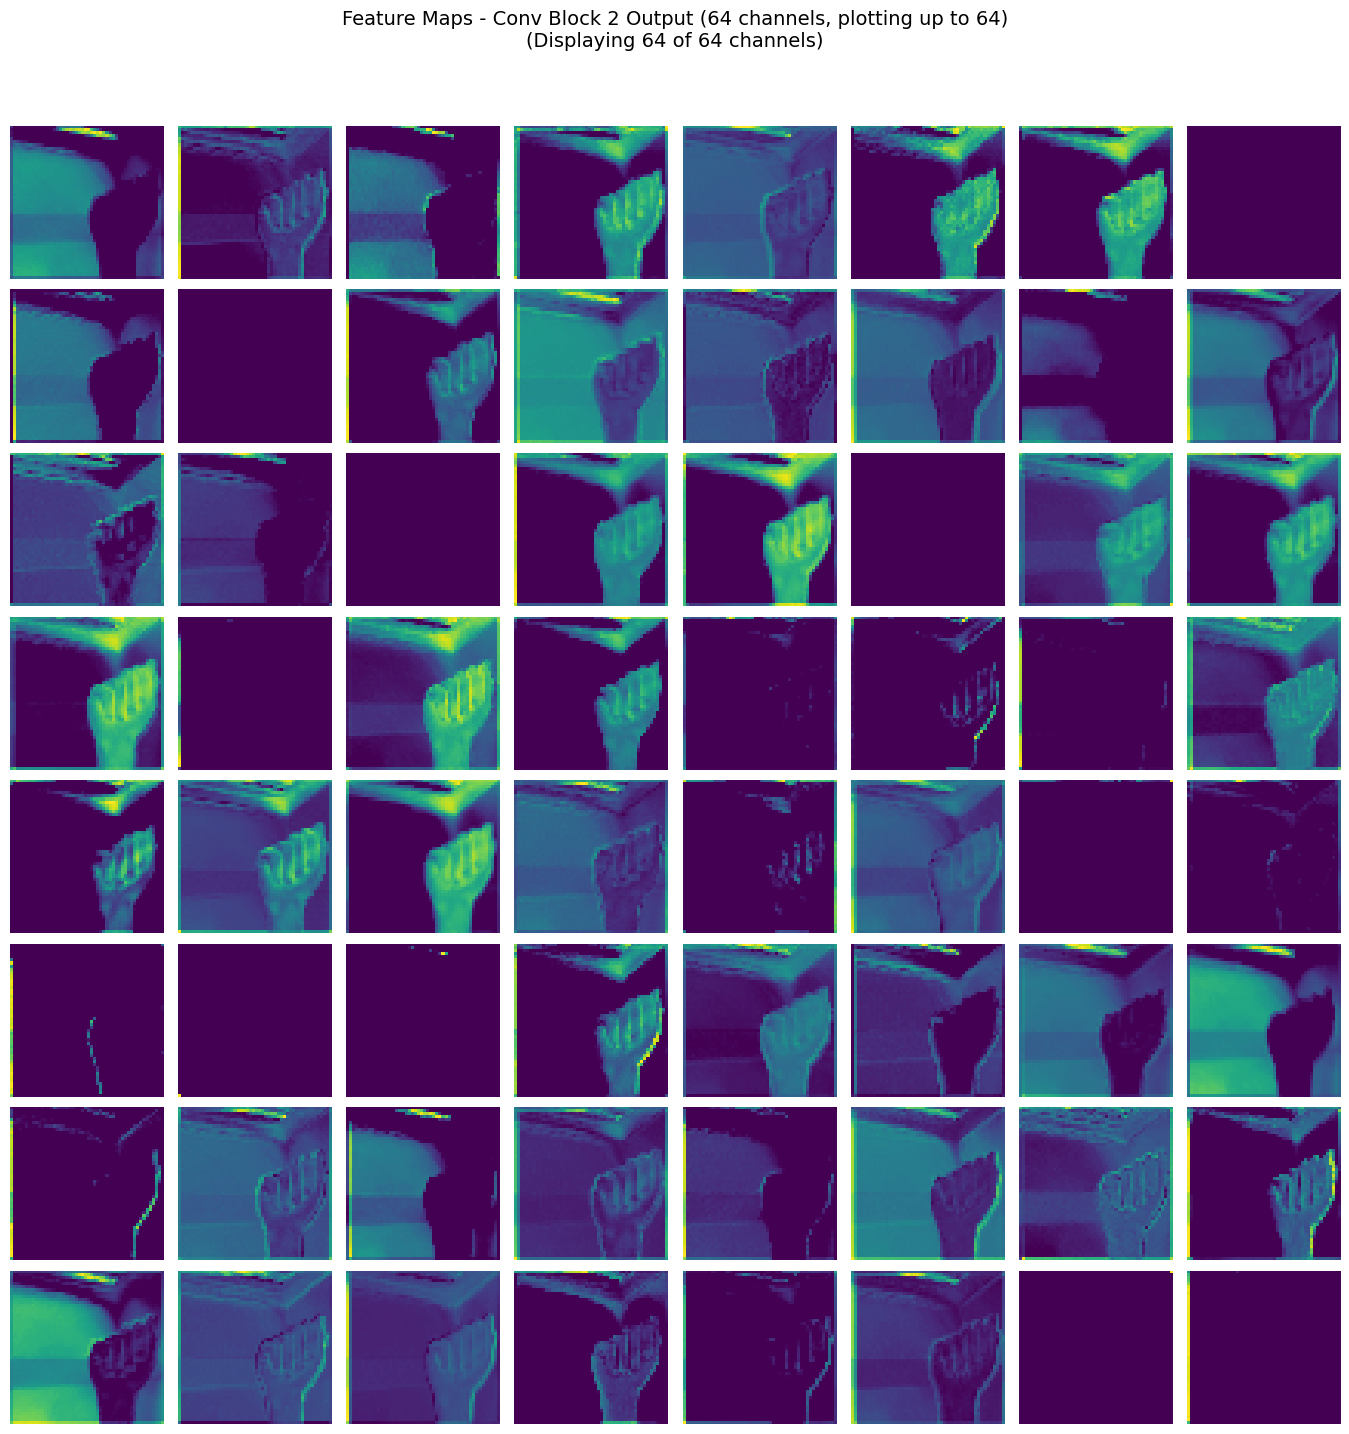


Plotting for Layer: Conv Block 3 Output (128 channels, plotting up to 128) (128 of 128 channels)


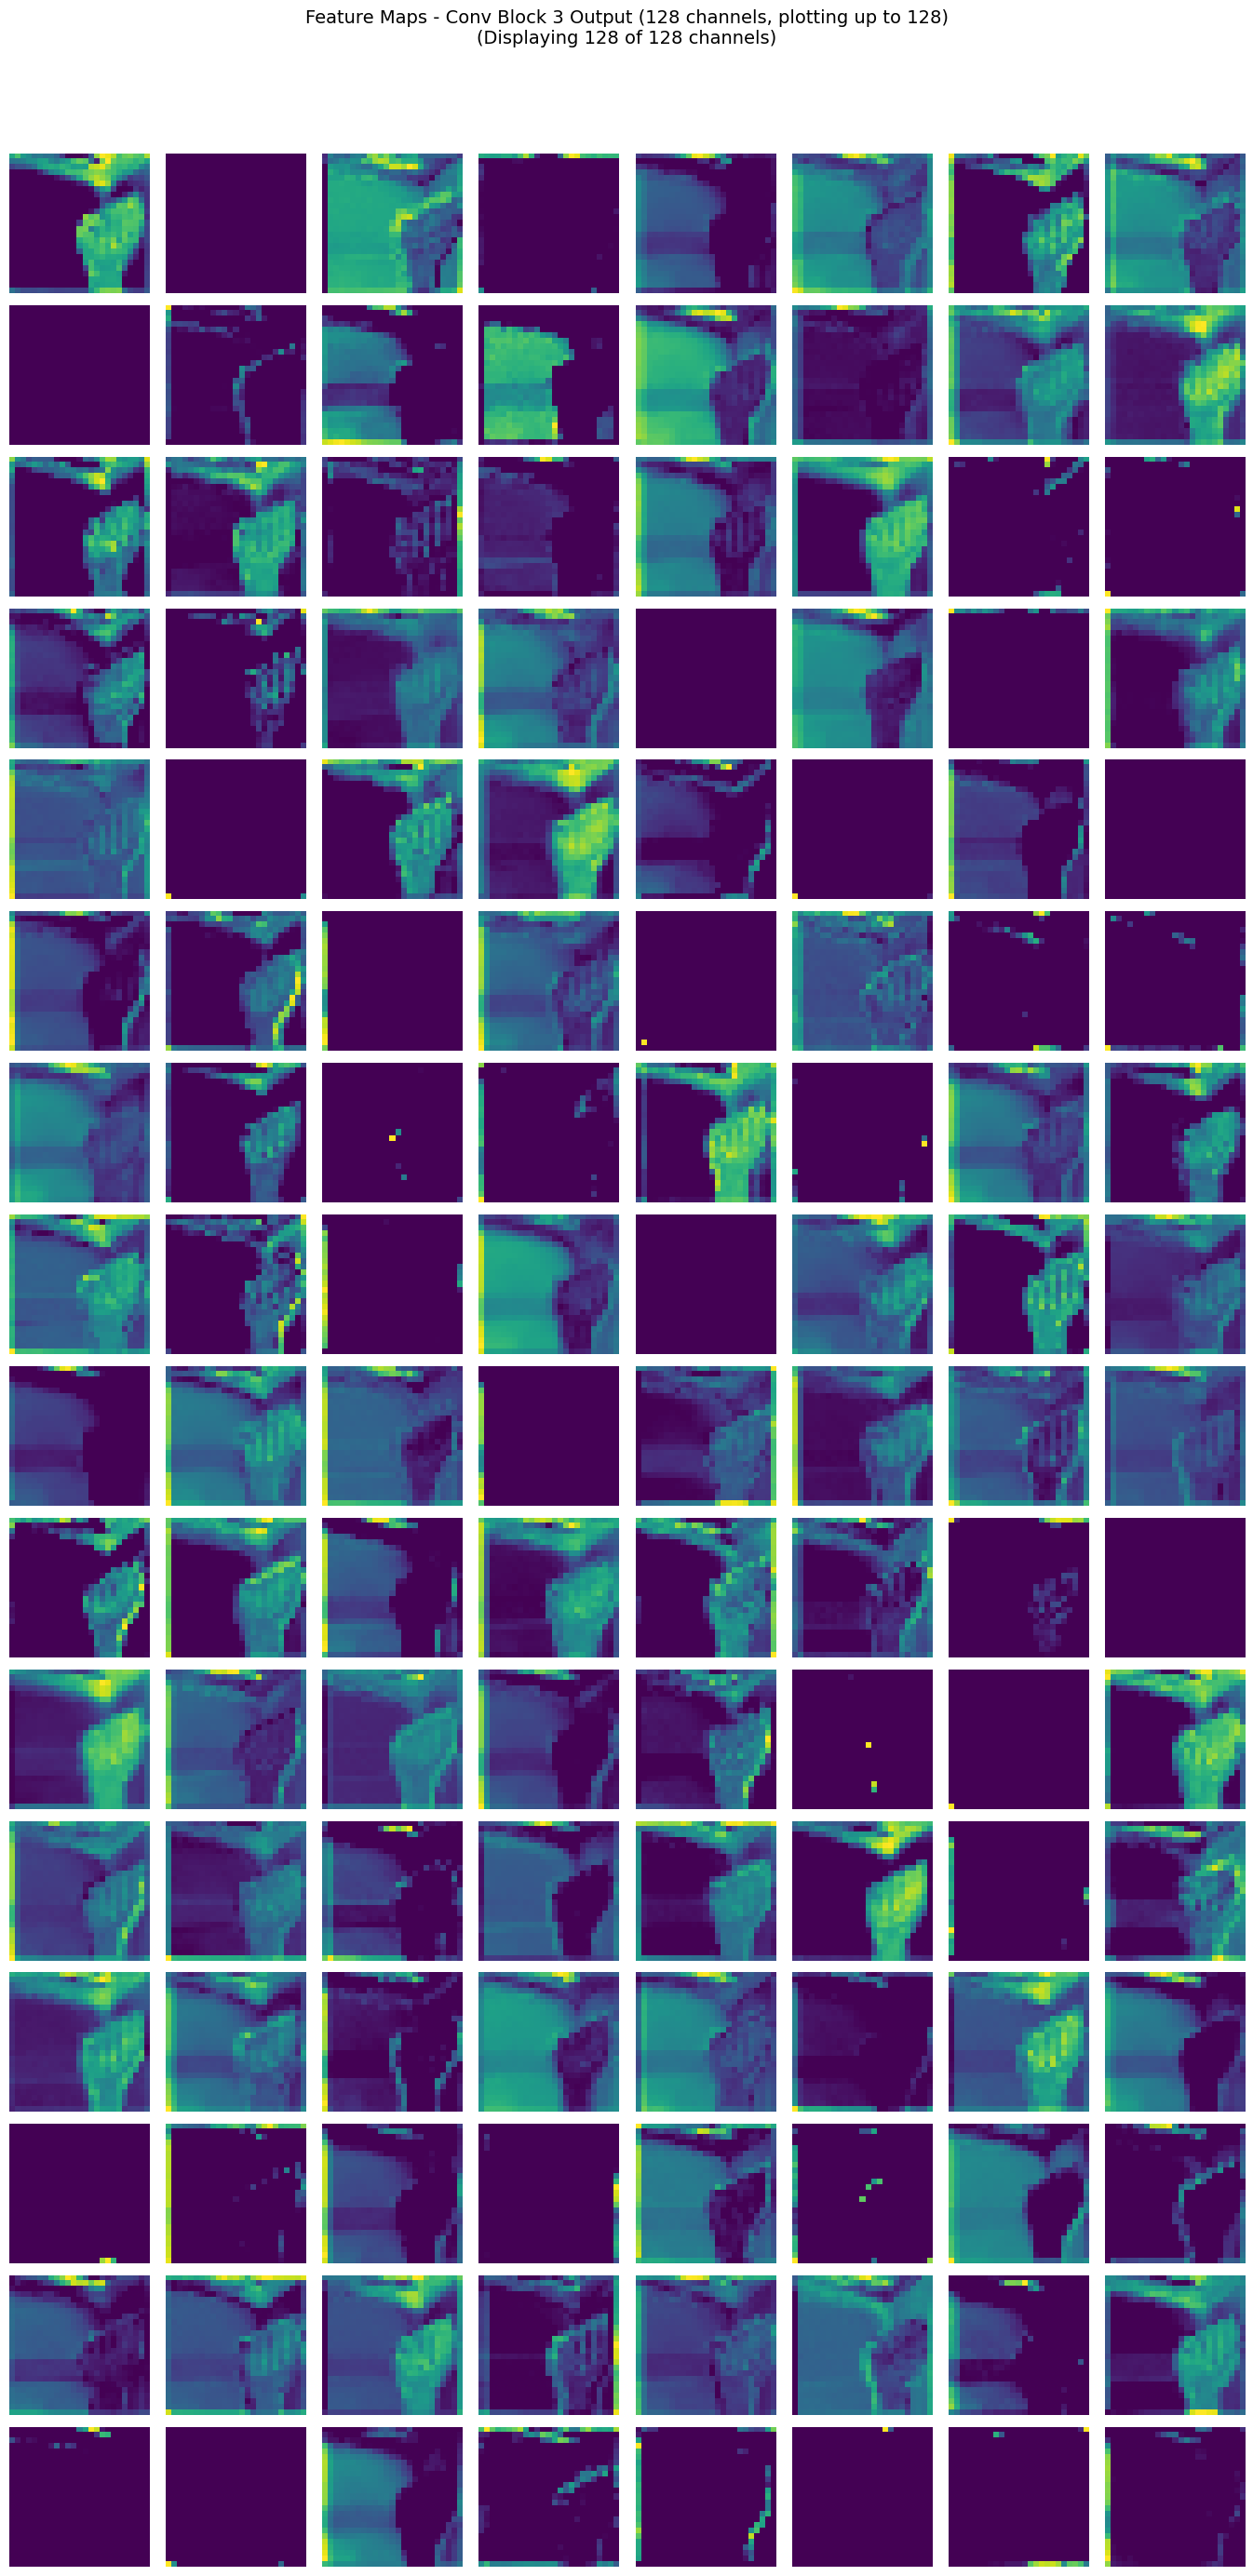

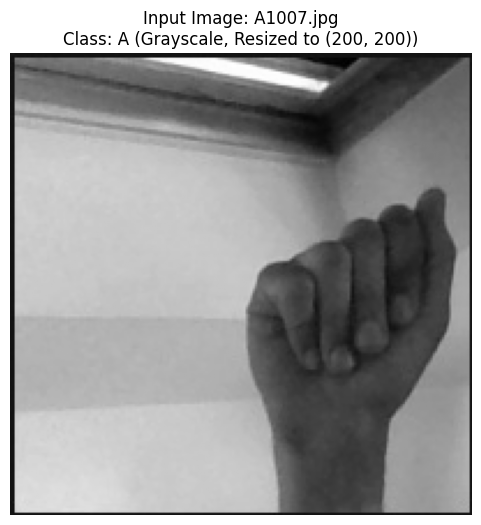

Hooks removed.


In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
# import random # Not needed if we use a specific image

# --- User's CNN Model Definition ---
NUM_CLASSES = 29 # IMPORTANT: Set this to the number of classes your model was trained on.

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, NUM_CLASSES)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# --- Configuration ---
# Specific image path provided by the user
SPECIFIC_IMAGE_PATH = "/content/ASL_totally_good/asl_alphabet_test/A/A1007.jpg"
TARGET_CLASS_NAME = "A" # Assuming it's an 'A' image
IMAGE_SIZE = (200, 200)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
# If you have pre-trained weights for this CNN:
# model.load_state_dict(torch.load('path/to/your_cnn_weights.pth', map_location=device))
model.eval()


# 1. Load the specific sample image
sample_img_path = SPECIFIC_IMAGE_PATH
sample_class_name = TARGET_CLASS_NAME

try:
    print(f"Loading image: {sample_img_path}")
    if not os.path.exists(sample_img_path):
        raise FileNotFoundError(f"Image file not found at: {sample_img_path}")
    sample_img_pil = Image.open(sample_img_path)
    print(f"Image loaded successfully: Mode={sample_img_pil.mode}, Size={sample_img_pil.size}")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the SPECIFIC_IMAGE_PATH is correct.")
    print("Using a placeholder black image for demonstration.")
    sample_img_pil = Image.new('L', IMAGE_SIZE, 0) # Placeholder, Grayscale 'L'
    # In case of error, sample_img_path will still be SPECIFIC_IMAGE_PATH for the title
    sample_class_name = "Error/Placeholder"
except Exception as e:
    print(f"An unexpected error occurred while loading the image: {e}")
    sample_img_pil = Image.new('L', IMAGE_SIZE, 0)
    sample_class_name = "Error/Placeholder"


# 2. Define transform (Resize to 200x200 and Grayscale)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# For displaying the original image (grayscaled and resized, but not normalized)
# This transform is applied to a *copy* of the loaded PIL image
display_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=1),
])
# Apply display transform only if image was loaded (or placeholder was created)
if sample_img_pil:
    sample_img_display_pil = display_transform(sample_img_pil.copy())
else: # Should not happen with current try-except, but as a safeguard
    sample_img_display_pil = Image.new('L', IMAGE_SIZE, 0)


# 3. Apply model's input transform and add batch dimension
# This uses the original sample_img_pil before the display_transform
sample_tensor = test_transform(sample_img_pil.copy()).unsqueeze(0).to(device)


# 4. Hook for feature maps
feature_maps = []
layer_names = [
    "Conv Block 1 Output (32 channels, plotting up to 8)",
    "Conv Block 2 Output (64 channels, plotting up to 64)",
    "Conv Block 3 Output (128 channels, plotting up to 128)"
]

def hook_fn(module, input, output):
    feature_maps.append(output.detach().cpu())

# 5. Register hooks
hooks = []
if hasattr(model, 'conv_layer') and isinstance(model.conv_layer, nn.Sequential):
    if len(model.conv_layer) > 2: hooks.append(model.conv_layer[2].register_forward_hook(hook_fn))
    else: print(f"Warning: Model 'conv_layer' too short to hook at index 2.")
    if len(model.conv_layer) > 5: hooks.append(model.conv_layer[5].register_forward_hook(hook_fn))
    else: print(f"Warning: Model 'conv_layer' too short to hook at index 5.")
    if len(model.conv_layer) > 8: hooks.append(model.conv_layer[8].register_forward_hook(hook_fn))
    else: print(f"Warning: Model 'conv_layer' too short to hook at index 8.")
    if not hooks: print("Error: No hooks were registered.")
elif not hasattr(model, 'conv_layer'): print("Error: Model does not have 'conv_layer' attribute.")
elif not isinstance(model.conv_layer, nn.Sequential): print("Error: Model 'conv_layer' is not an nn.Sequential.")


# 6. Forward pass
if hooks:
    with torch.no_grad():
        try:
            _ = model(sample_tensor)
            print(f"Forward pass completed. Captured {len(feature_maps)} feature map sets.")
            if len(feature_maps) != len(hooks):
                 print(f"Warning: Expected {len(hooks)} sets, got {len(feature_maps)}.")
        except Exception as e:
            print(f"Error during forward pass: {e}")
            feature_maps = []
else:
    print("Skipping forward pass as no hooks were registered.")


# 7. Plot feature maps
def plot_feature_maps_custom(f_maps, l_names, target_channel_counts):
    if not f_maps:
        print("No feature maps to plot.")
        return
    for layer_idx, (fm, layer_name) in enumerate(zip(f_maps, l_names)):
        if layer_idx >= len(target_channel_counts):
            print(f"Warning: Not enough target counts for layer {layer_name}.")
            continue
        fm_numpy = fm.squeeze(0).numpy()
        num_channels_available = fm_numpy.shape[0]
        channels_to_plot = min(num_channels_available, target_channel_counts[layer_idx])
        print(f"\nPlotting for Layer: {layer_name} ({channels_to_plot} of {num_channels_available} channels)")
        if channels_to_plot == 0: continue
        cols = 8
        rows = (channels_to_plot + cols - 1) // cols
        plt.figure(figsize=(cols * 1.7, rows * 1.7 + 1))
        for i in range(channels_to_plot):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(fm_numpy[i], cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"Feature Maps - {layer_name}\n(Displaying {channels_to_plot} of {num_channels_available} channels)", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

desired_channels_to_plot_per_layer = [8, 64, 128]
if feature_maps:
    plot_feature_maps_custom(
        feature_maps,
        layer_names[:len(feature_maps)],
        desired_channels_to_plot_per_layer[:len(feature_maps)]
    )
else:
    print("No feature maps captured, skipping plotting.")

# 8. Show original image (grayscaled, resized, unnormalized)
# Ensure sample_img_display_pil is valid before converting to numpy
if sample_img_display_pil:
    original_img_array_display = np.array(sample_img_display_pil)
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img_array_display, cmap='gray')
    plt.title(f"Input Image: {os.path.basename(sample_img_path)}\nClass: {sample_class_name} (Grayscale, Resized to {IMAGE_SIZE})", fontsize=12)
    plt.axis('off')
    plt.show()
else:
    print("Could not display the input image because it was not loaded properly.")

# 9. Don't forget to remove hooks
for hook in hooks:
    hook.remove()
if hooks:
    print("Hooks removed.")

## Additional Ideas
* experiment w/ **Data Augmentation** techniques;
* experiment w/ **transfer learning (VGG-16/ResNet/... and fine-tune them)**